<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Object_Detection_with_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Object detection with Vision Transformers*

# **Introduction**

The article Vision Transformer (ViT) architecture by Alexey Dosovitskiy et al. demonstrates that a pure transformer applied directly to sequences of image patches can perform well on object detection tasks.

In this Keras example, we implement an object detection ViT and we train it on the Caltech 101 dataset to detect an airplane in the given image.
This example requires TensorFlow 2.4 or higher, and TensorFlow Addons, from which we import the AdamW optimizer.

In [1]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.2 MB/s eta 0:00:00


In [2]:
import os
import cv2
import shutil
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# **Prepare dataset**

We use the Caltech 101 Dataset.

In [3]:
path_images = "/101_ObjectCategories/airplanes/"
path_annot = "/Annotations/Airplanes_Side_2/"

path_to_download_file = keras.utils.get_file(
    fname = "caltech_101_zipped",
    origin = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract = True,
    archive_format = "zip",
    cache_dir = "/")

137414764/137414764 [==============================] - 9s 0us/step


In [4]:
path_to_download_file

'/datasets/caltech_101_zipped'

In [5]:
shutil.unpack_archive("/datasets/caltech-101/101_ObjectCategories.tar.gz", "/")
shutil.unpack_archive("/datasets/caltech-101/Annotations.tar", "/")

In [6]:
image_paths = [x for x in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, x))]
annot_paths = [x for x in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, x))]

In [7]:
image_paths.sort()
annot_paths.sort()

In [8]:
scipy.io.loadmat(path_annot + annot_paths[0])["box_coord"][0]

array([ 30, 137,  49, 349], dtype=uint16)

In [9]:
img_size = 224

images = []
targets = []

for i in range(0, len(annot_paths)):
  annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]
  top_left_x, top_left_y = annot[2], annot[0]
  bottom_right_x, bottom_right_y = annot[3], annot[1]

  image = keras.utils.load_img(path_images + image_paths[i])
  (w, h) = image.size[:2]

  if i < int(len(annot_paths) * 0.8):
    image = image.resize((img_size, img_size))

  images.append(keras.utils.img_to_array(image))
  targets.append(
    (
      float(top_left_x) / w,
      float(top_left_y) / h,
      float(bottom_right_x) / w,
      float(bottom_right_y) / h
    ))

In [10]:
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

<ipython-input-10-6c66826c3338>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


In [11]:
x_train.shape, y_train.shape

((640, 224, 224, 3), (640, 4))

#**Implement multilayer-perceptron (MLP)**


We use the code from the Keras example Image classification with Vision Transformer as a reference.

In [12]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

# **Implement the patch creation layer**

In [13]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def get_config(self):
    config = super().get_config().copy()
    config.update(
      {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
       }
    )
    return config

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
      images = images,
      sizes = [1, self.patch_size, self.patch_size, 1],
      strides = [1, self.patch_size, self.patch_size, 1],
      rates = [1, 1, 1, 1],
      padding = "VALID"
    )
    return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


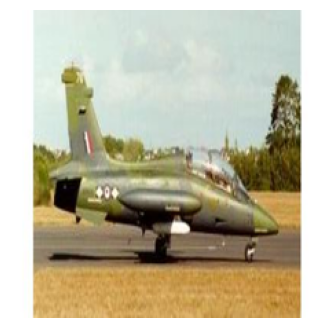

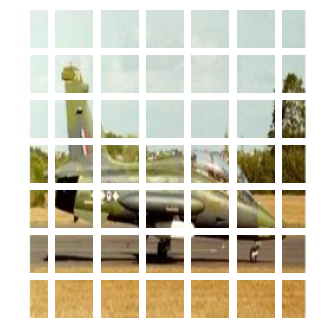

In [15]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {img_size} X {img_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

#**Implement the patch encoding layer**


The PatchEncoder layer linearly transforms a patch by projecting it into a vector of size projection_dim. It also adds a learnable position embedding to the projected vector.

In [22]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units = projection_dim)
    self.positional_embedding = layers.Embedding(input_dim = num_patches, output_dim = projection_dim)

  def get_config(self):
    config = super().get_config().copy()
    config.update(
      {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
       }
    )
    return config


  def call(self, patch):
    positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
    encoded = self.projection(patch) + self.positional_embedding(positions)
    return encoded

# **Build the ViT model**


The ViT model has multiple Transformer blocks. The MultiHeadAttention layer is used for self-attention, applied to the sequence of image patches. The encoded patches (skip connection) and self-attention layer outputs are normalized and fed into a multilayer perceptron (MLP). The model outputs four dimensions representing the bounding box coordinates of an object.

In [23]:
def create_vit_object_detector(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units):

  inputs = layers.Input(shape = input_shape)

  patches = Patches(patch_size)(inputs)

  encoded_patches = PatchEncoder(num_patches,  projection_dim)(patches)


  for _ in range(transformer_layers):

    x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)

    attention_output = layers.MultiHeadAttention(num_heads = num_heads, key_dim = projection_dim, dropout = 0.1)(x1, x1)

    x2 = layers.Add()([attention_output, encoded_patches])

    x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)

    x4 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)

    encoded_patches = layers.Add()([x4, x2])


  representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)

  representation = layers.Flatten()(representation)

  representation = layers.Dropout(0.3)(representation)

  features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.3)

  bounding_box = layers.Dense(4)(features)

  return keras.Model(inputs = inputs, outputs = bounding_box)

In [25]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

  optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay = weight_decay)

  model.compile(optimizer = optimizer, loss = keras.losses.MeanSquaredError())

  checkpoint_path = "logs/"
  checkpoint_callbacks = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = True)

  history = model.fit(
      x = x_train,
      y = y_train,
      validation_split = 0.1,
      batch_size = batch_size,
      epochs = num_epochs,
      callbacks = [
          checkpoint_callbacks,
          keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)
      ])
  return history

In [29]:
input_shape = (img_size, img_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
num_patches = (img_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers


history = []
num_patches = (img_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
18/18 [==============================] - 15s 463ms/step - loss: 0.7871 - val_loss: 0.3544
Epoch 2/100
18/18 [==============================] - 9s 478ms/step - loss: 0.3748 - val_loss: 0.3050
Epoch 3/100
18/18 [==============================] - 8s 469ms/step - loss: 0.2842 - val_loss: 0.2772
Epoch 4/100
18/18 [==============================] - 7s 396ms/step - loss: 0.2135 - val_loss: 0.0567
Epoch 5/100
18/18 [==============================] - 9s 480ms/step - loss: 0.1458 - val_loss: 0.0333
Epoch 6/100
18/18 [==============================] - 7s 408ms/step - loss: 0.0831 - val_loss: 0.0019
Epoch 7/100
18/18 [==============================] - 8s 475ms/step - loss: 0.0532 - val_loss: 0.0012
Epoch 8/100
18/18 [==============================] - 8s 449ms/step - loss: 0.0391 - val_loss: 0.0035
Epoch 9/100
18/18 [==============================] - 7s 378ms/step - loss: 0.0315 - val_loss: 0.0101
Epoch 10/100
18/18 [==============================] - 8s 448ms/step - loss: 0.0273 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step
mean_iou: 0.7627182402063648


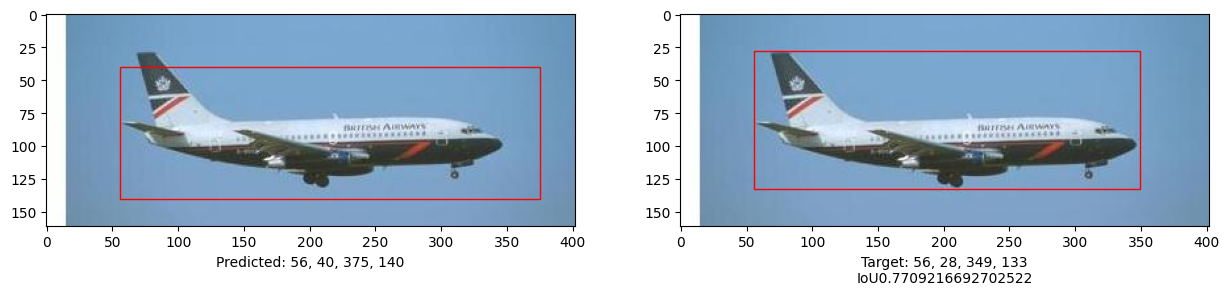

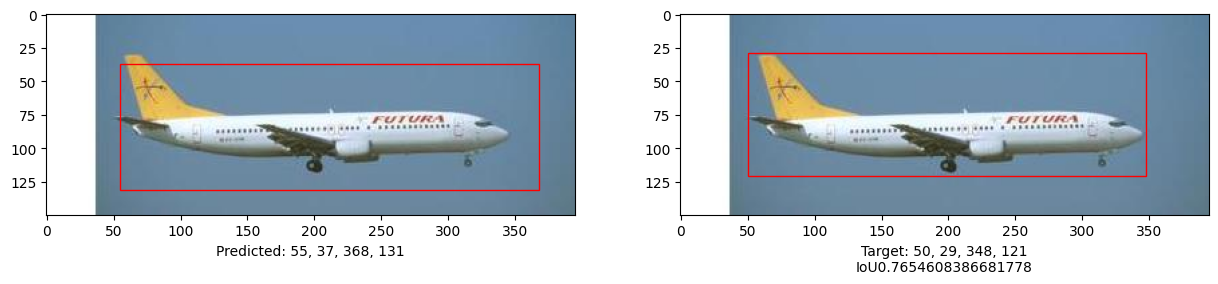

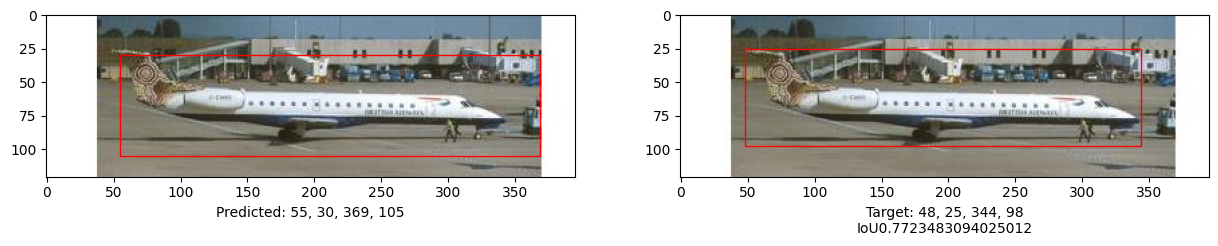

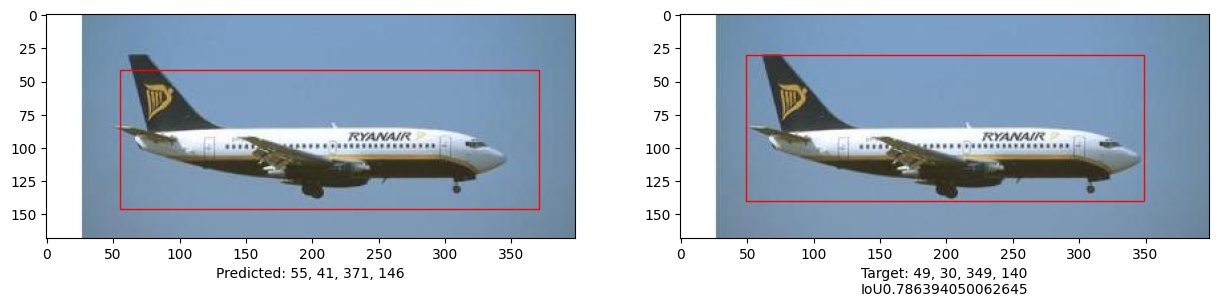

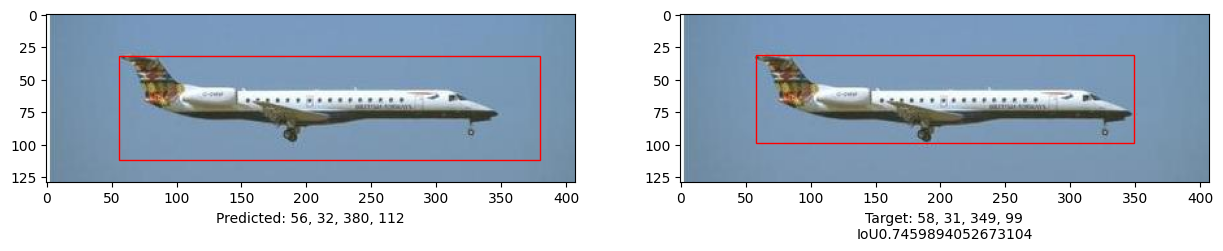

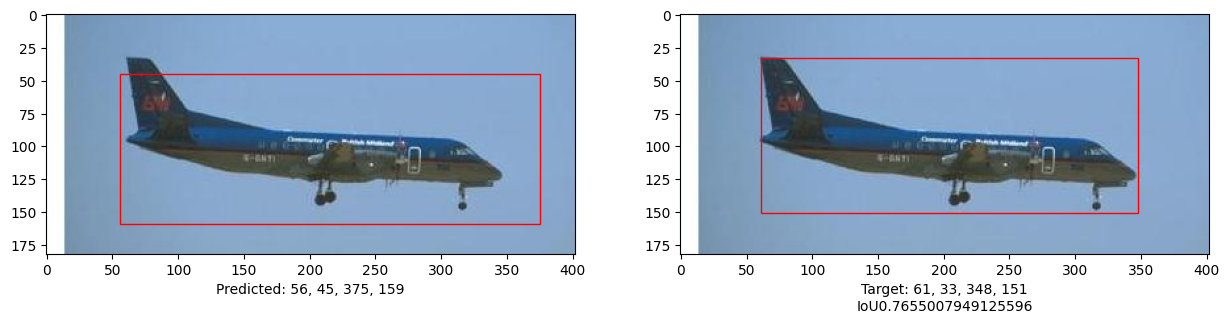

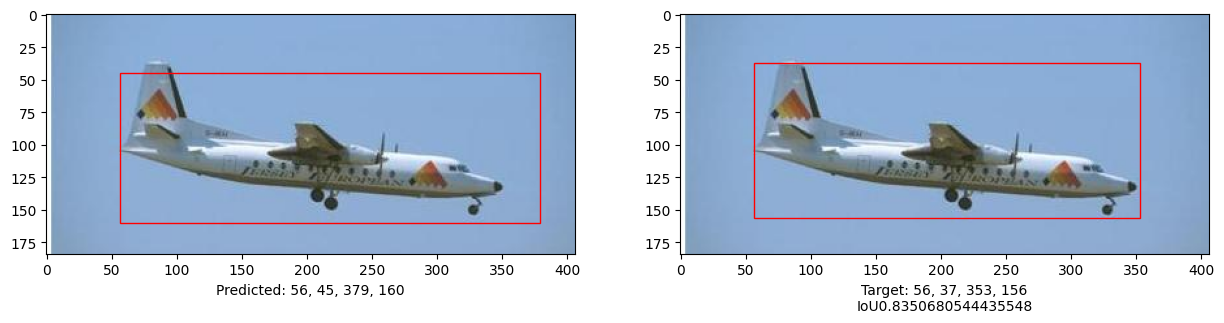

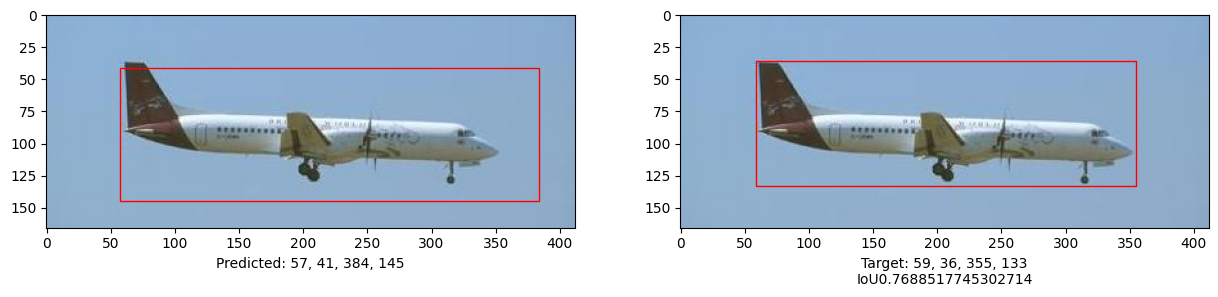

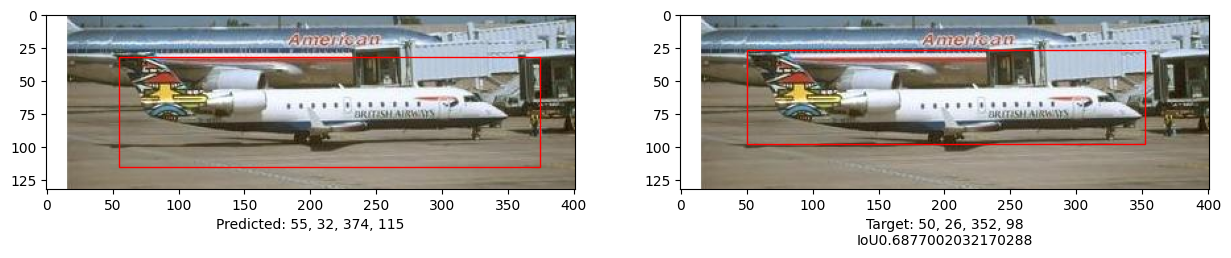

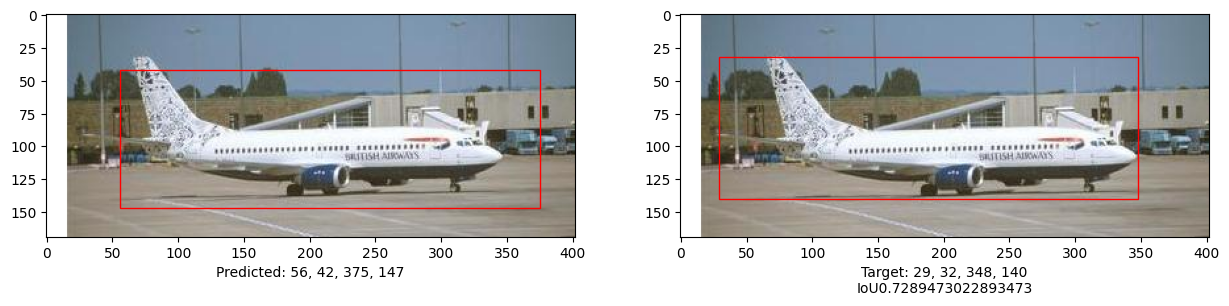

In [30]:
import matplotlib.patches as patches

# Saves the model in current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (img_size, img_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

**This example demonstrates that a pure Transformer can be trained to predict the bounding boxes of an object in a given image, thus extending the use of Transformers to object detection tasks. The model can be improved further by tuning hyper-parameters and pre-training.**